In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline
#%matplotlib notebook
plt.style.use('ggplot')

In [26]:
#see all available columns
pd.set_option('display.max_columns', None)

#reads in each csv separately
pitches = pd.read_csv('../data/pitches.csv', low_memory=False)

atbats = pd.read_csv('../data/atbats.csv', low_memory=False)

ejections = pd.read_csv('../data/ejections.csv', low_memory=False)

games = pd.read_csv('../data/games.csv', low_memory=False)

names = pd.read_csv('../data/player_names.csv', low_memory=False)

Text(0, 0.5, 'Height of Pitch')

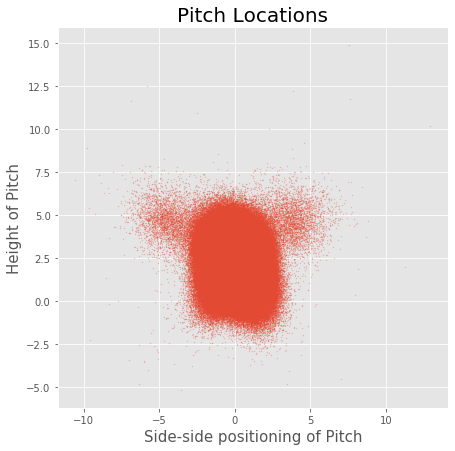

In [17]:
#plots pitch locations
plt.figure(figsize=(7,7))
plt.scatter(pitches['px'].values, pitches['pz'].values, alpha=0.2, s=1)
plt.title('Pitch Locations', size=20)
plt.xlabel('Side-side positioning of Pitch', size=15)
plt.ylabel('Height of Pitch', size=15)

In [18]:
pitches.shape

(2867154, 40)

In [19]:
atbats.shape

(740389, 11)

In [20]:
names.shape

(2218, 3)

In [21]:
ejections.shape

(761, 10)

In [22]:
games.shape

(9718, 17)

In [27]:
#finds all nans and uses np.where to grab axis [0] grabs first of tuple
rows_with_nans = np.where(pitches.isna().any(axis=1) == True)[0]
#new df with dropped nans
pitches.drop(index=rows_with_nans, axis=0)

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,ay,az,sz_bot,sz_top,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,nasty,zone,code,type,pitch_type,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,0.416000,2.963000,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665000,34.685000,-11.960000,1.720000,3.560000,2.000,-6.409000,-136.065000,-3.995000,101.140000,2.280000,158.780000,50.0,5.302000,4.160000,10.930000,55.0,3.0,C,S,FF,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.191000,2.347000,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043000,34.225000,-10.085000,1.720000,3.560000,2.000,-8.411000,-135.690000,-5.980000,124.280000,2.119000,175.410000,50.0,5.307000,6.570000,12.000000,31.0,5.0,S,S,FF,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,-0.518000,3.284000,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368000,35.276000,-11.560000,1.720000,3.560000,2.000,-9.802000,-137.668000,-3.337000,136.740000,2.127000,150.110000,50.0,5.313000,7.610000,10.880000,49.0,1.0,F,S,FF,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,-0.641000,1.221000,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104000,28.354000,-20.540000,1.740000,3.350000,2.000,-8.071000,-133.005000,-6.567000,109.685636,2.279000,187.463482,50.0,5.210000,1.170000,6.450000,41.0,13.0,B,B,FF,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,-1.821000,2.083000,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280000,21.774000,-34.111000,1.720000,3.560000,2.000,-6.309000,-110.409000,0.325000,146.527525,2.179000,177.242829,50.0,5.557000,-8.430000,-1.650000,18.0,13.0,B,B,CU,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2867149,0.230280,1.784910,83.9,78.2,608.594,275.800,10.5,8.8,23.9,-5.097492,20.344010,-32.691751,1.535000,3.371000,0.908,-6.895539,-122.140540,-0.859601,108.220000,3.502933,190.580000,50.0,4.912177,-3.319733,-0.337153,27.0,8.0,D,X,SL,568,1.0,2.018186e+09,3.0,2.0,2.0,9.0,0.0,0.0,0.0
2867150,-1.211049,2.479020,97.7,89.5,2262.907,155.009,-26.9,2.9,23.8,9.344343,29.592944,-12.127944,1.865118,3.760455,0.892,-12.912992,-141.795182,-5.100730,163.160000,2.792346,171.850000,50.0,5.061932,4.547344,9.755265,63.0,13.0,B,B,FF,572,1.0,2.018186e+09,0.0,0.0,2.0,1.0,1.0,0.0,0.0
2867151,-0.444578,2.619287,97.3,89.6,2514.010,147.166,-40.5,3.3,23.8,13.292081,30.048939,-11.576431,1.601000,3.490000,0.898,-12.095230,-141.465465,-4.717196,133.950000,3.026107,168.060000,50.0,5.040691,6.511325,10.090051,30.0,4.0,F,S,FF,577,1.0,2.018186e+09,1.0,0.0,2.0,2.0,0.0,1.0,0.0
2867152,-0.259813,1.336484,95.9,88.6,2318.775,144.921,-34.2,3.8,23.8,12.786338,28.690698,-13.967178,1.601000,3.490000,0.910,-11.422113,-139.199258,-7.246702,126.910000,3.041058,202.740000,50.0,4.881930,6.460353,9.199100,42.0,13.0,S,S,FF,578,1.0,2.018186e+09,1.0,1.0,2.0,3.0,0.0,1.0,0.0


<Figure size 648x504 with 0 Axes>

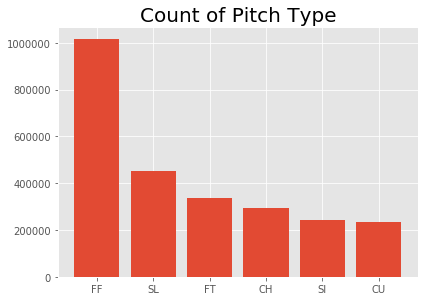

<Figure size 648x504 with 0 Axes>

In [28]:
#x is the count of each pitch sorted
x = pitches.groupby('pitch_type').count().sort_values('px').iloc[:, 0].values[:-7:-1]
#pitch is the index of different pitches
pitch = pitches.groupby('pitch_type').count().sort_values('px').iloc[:, 0].index[:-7:-1]

plt.bar(pitch, x)
plt.tight_layout()
plt.title('Count of Pitch Type', size=20)
plt.figure(figsize=(9,7))

In [29]:
#pca need to plot these compositions with every different pitch type and look to see a difference
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_comps = pca.fit_transform(pitches.drop(index=rows_with_nans, axis=0).iloc[:, :8])

In [30]:
#top 6 most common pitches
top_6_labels = pitches.groupby('pitch_type').count().sort_values('px').iloc[:, 0].index[::-1][:6]

#first feature of pca with 2 components
x = pca_comps[:, 0]
#second feature of pac with 2 components
y = pca_comps[:, 1]
#labels of each pitch type for each row in pitches
pitch_type = pitches.drop(index=rows_with_nans, axis=0)['pitch_type'].values

Plot took 7.042595148086548 to show


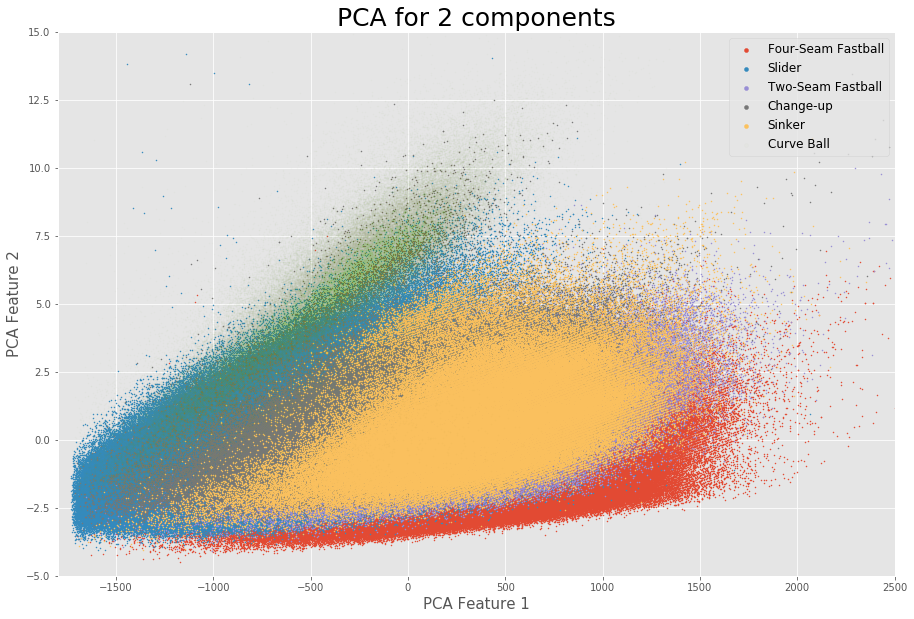

In [31]:
#grabs current time
current = time.time()
#dictionary to have nice plotting of types of pitches
dic = {'FF':'Four-Seam Fastball', 'SL': 'Slider', 'FT': 'Two-Seam Fastball', 'CH': 'Change-up', 'SI': 'Sinker', 'CU': 'Curve Ball'}


plt.figure(figsize=(15,10))
for label in top_6_labels:
    line = plt.scatter(x[pitch_type == label], y[pitch_type == label], label=label, s=1)
plt.title('PCA for 2 components', size=25)
line.set_alpha(0.02)
plt.xlabel('PCA Feature 1', size=15)
plt.ylabel('PCA Feature 2', size=15)
plt.ylim(-5, 15)
plt.xlim(-1800, 2500)
#plt.legend doesnt want to work??
plt.legend(loc=1, markerscale=4, fontsize='large', labels=dic.values())
plt.savefig('../Graphics/PCA_2_test.png', dpi=100);
print('Plot took {} to show'.format(time.time() - current))

In [32]:
atbats[atbats['ab_id'] == 2015000001]

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True


In [33]:
pitches[pitches['ab_id'] == 2015000001]

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,ay,az,sz_bot,sz_top,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,nasty,zone,code,type,pitch_type,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,34.685,-11.960,1.72,3.56,2.0,-6.409,-136.065,-3.995,101.140000,2.280,158.780000,50.0,5.302,4.16,10.93,55.0,3.0,C,S,FF,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,34.225,-10.085,1.72,3.56,2.0,-8.411,-135.690,-5.980,124.280000,2.119,175.410000,50.0,5.307,6.57,12.00,31.0,5.0,S,S,FF,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,35.276,-11.560,1.72,3.56,2.0,-9.802,-137.668,-3.337,136.740000,2.127,150.110000,50.0,5.313,7.61,10.88,49.0,1.0,F,S,FF,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,-0.641,1.221,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104,28.354,-20.540,1.74,3.35,2.0,-8.071,-133.005,-6.567,109.685636,2.279,187.463482,50.0,5.210,1.17,6.45,41.0,13.0,B,B,FF,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,21.774,-34.111,1.72,3.56,2.0,-6.309,-110.409,0.325,146.527525,2.179,177.242829,50.0,5.557,-8.43,-1.65,18.0,13.0,B,B,CU,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0
5,0.627,2.397,92.9,84.8,2743.856,148.110,-45.7,3.7,23.7,13.590,32.274,-10.333,1.72,3.56,2.0,-6.943,-136.012,-5.738,118.004772,2.273,164.467012,50.0,5.264,7.32,11.72,42.0,6.0,X,X,FF,8,0.0,2.015000e+09,2.0,2.0,0.0,6.0,0.0,0.0,0.0


## Takeaways from EDA
Predicting the pitch type based on the count, the pitcher, (the previous pitches??), the score, runners on 1st, 2nd, 3rd, the number of pitches thrown so far, pitcher left handed/right handed, the batter handedness, inning, so much more...

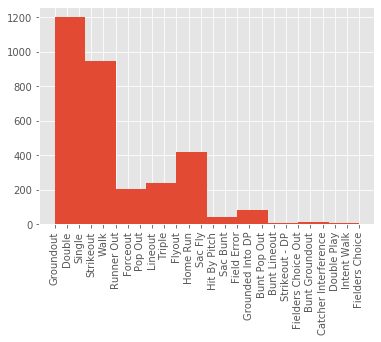

In [34]:
atbats[(atbats['pitcher_id'] == 452657)]['event'].hist()
plt.xticks(rotation=90);

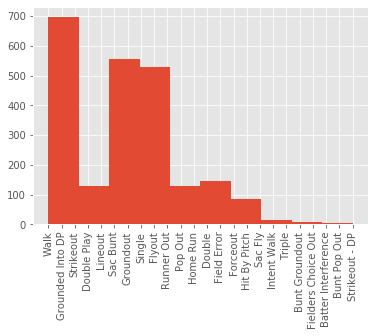

In [35]:
atbats[(atbats['pitcher_id'] == 448802)]['event'].hist()
plt.xticks(rotation=90);

In [36]:
atbats[(atbats['pitcher_id'] == 452657) & (atbats['batter_id'] == 572761)] .groupby(['pitcher_id', 'batter_id']).count()

,,ab_id,event,g_id,inning,o,p_score,p_throws,stand,top
pitcher_id,batter_id,,,,,,,,,
452657,572761,47,47,47,47,47,47,47,47,47


In [37]:
pitches

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,ay,az,sz_bot,sz_top,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,nasty,zone,code,type,pitch_type,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,0.416000,2.963000,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665000,34.685000,-11.960000,1.720000,3.560000,2.000,-6.409000,-136.065000,-3.995000,101.140000,2.280000,158.780000,50.0,5.302000,4.160000,10.930000,55.0,3.0,C,S,FF,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.191000,2.347000,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043000,34.225000,-10.085000,1.720000,3.560000,2.000,-8.411000,-135.690000,-5.980000,124.280000,2.119000,175.410000,50.0,5.307000,6.570000,12.000000,31.0,5.0,S,S,FF,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,-0.518000,3.284000,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368000,35.276000,-11.560000,1.720000,3.560000,2.000,-9.802000,-137.668000,-3.337000,136.740000,2.127000,150.110000,50.0,5.313000,7.610000,10.880000,49.0,1.0,F,S,FF,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,-0.641000,1.221000,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104000,28.354000,-20.540000,1.740000,3.350000,2.000,-8.071000,-133.005000,-6.567000,109.685636,2.279000,187.463482,50.0,5.210000,1.170000,6.450000,41.0,13.0,B,B,FF,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,-1.821000,2.083000,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280000,21.774000,-34.111000,1.720000,3.560000,2.000,-6.309000,-110.409000,0.325000,146.527525,2.179000,177.242829,50.0,5.557000,-8.430000,-1.650000,18.0,13.0,B,B,CU,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2867149,0.230280,1.784910,83.9,78.2,608.594,275.800,10.5,8.8,23.9,-5.097492,20.344010,-32.691751,1.535000,3.371000,0.908,-6.895539,-122.140540,-0.859601,108.220000,3.502933,190.580000,50.0,4.912177,-3.319733,-0.337153,27.0,8.0,D,X,SL,568,1.0,2.018186e+09,3.0,2.0,2.0,9.0,0.0,0.0,0.0
2867150,-1.211049,2.479020,97.7,89.5,2262.907,155.009,-26.9,2.9,23.8,9.344343,29.592944,-12.127944,1.865118,3.760455,0.892,-12.912992,-141.795182,-5.100730,163.160000,2.792346,171.850000,50.0,5.061932,4.547344,9.755265,63.0,13.0,B,B,FF,572,1.0,2.018186e+09,0.0,0.0,2.0,1.0,1.0,0.0,0.0
2867151,-0.444578,2.619287,97.3,89.6,2514.010,147.166,-40.5,3.3,23.8,13.292081,30.048939,-11.576431,1.601000,3.490000,0.898,-12.095230,-141.465465,-4.717196,133.950000,3.026107,168.060000,50.0,5.040691,6.511325,10.090051,30.0,4.0,F,S,FF,577,1.0,2.018186e+09,1.0,0.0,2.0,2.0,0.0,1.0,0.0
2867152,-0.259813,1.336484,95.9,88.6,2318.775,144.921,-34.2,3.8,23.8,12.786338,28.690698,-13.967178,1.601000,3.490000,0.910,-11.422113,-139.199258,-7.246702,126.910000,3.041058,202.740000,50.0,4.881930,6.460353,9.199100,42.0,13.0,S,S,FF,578,1.0,2.018186e+09,1.0,1.0,2.0,3.0,0.0,1.0,0.0


In [38]:
#this pitcher has seen every batter on average of 6 times each 
atbats[(atbats['pitcher_id'] == 452657)] .groupby(['pitcher_id', 'batter_id']).count().mean()

ab_id       6.203523
event       6.203523
g_id        6.203523
inning      6.203523
o           6.203523
p_score     6.203523
p_throws    6.203523
stand       6.203523
top         6.203523
dtype: float64

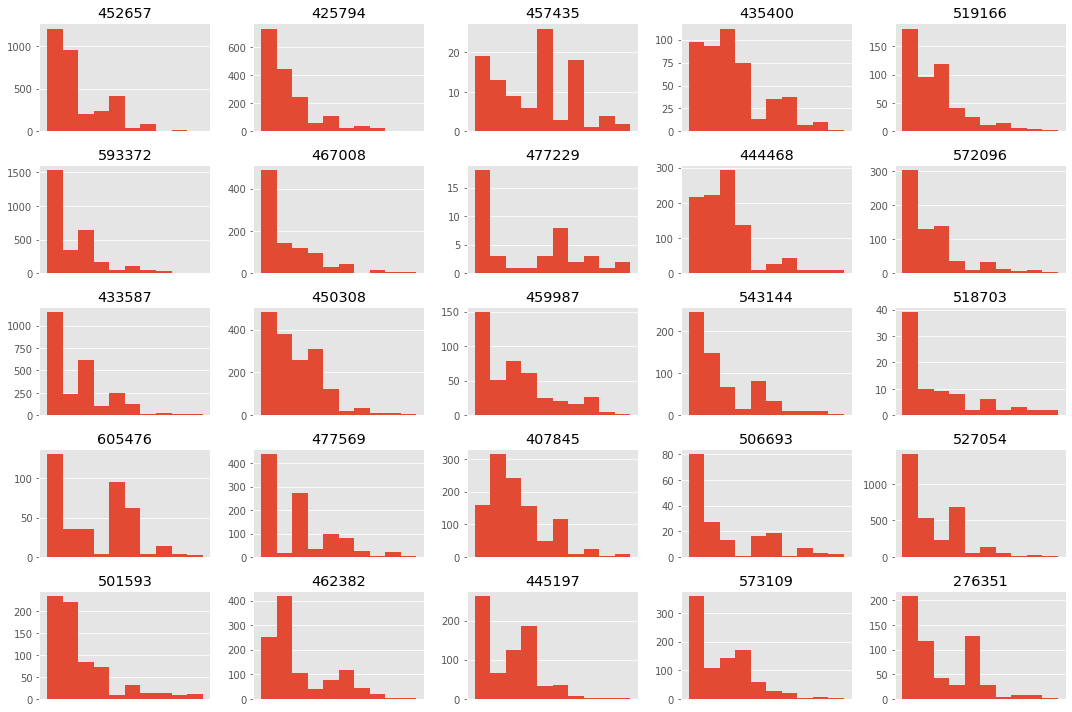

In [40]:
#looks at different pitchers and the results of all of the batters they see
fig, ax = plt.subplots(5, 5, figsize=(15, 10))
for pitcher, ax in zip(atbats['pitcher_id'].unique()[:50], ax.flatten()):
    ax.hist(atbats[atbats['pitcher_id'] == pitcher]['event'].values)
    ax.set_xticks([])
    ax.set_title(pitcher)
    
plt.tight_layout()
    

In [41]:
#in order to get a better picture lets merge atbats with pitches to see the different pictures
game_sit = pd.merge(atbats, pitches[['pitch_type', 'b_score', 'b_count', 's_count', 'ab_id']], on='ab_id')

In [42]:
pitches

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,ay,az,sz_bot,sz_top,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,nasty,zone,code,type,pitch_type,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,0.416000,2.963000,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665000,34.685000,-11.960000,1.720000,3.560000,2.000,-6.409000,-136.065000,-3.995000,101.140000,2.280000,158.780000,50.0,5.302000,4.160000,10.930000,55.0,3.0,C,S,FF,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.191000,2.347000,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043000,34.225000,-10.085000,1.720000,3.560000,2.000,-8.411000,-135.690000,-5.980000,124.280000,2.119000,175.410000,50.0,5.307000,6.570000,12.000000,31.0,5.0,S,S,FF,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,-0.518000,3.284000,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368000,35.276000,-11.560000,1.720000,3.560000,2.000,-9.802000,-137.668000,-3.337000,136.740000,2.127000,150.110000,50.0,5.313000,7.610000,10.880000,49.0,1.0,F,S,FF,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,-0.641000,1.221000,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104000,28.354000,-20.540000,1.740000,3.350000,2.000,-8.071000,-133.005000,-6.567000,109.685636,2.279000,187.463482,50.0,5.210000,1.170000,6.450000,41.0,13.0,B,B,FF,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,-1.821000,2.083000,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280000,21.774000,-34.111000,1.720000,3.560000,2.000,-6.309000,-110.409000,0.325000,146.527525,2.179000,177.242829,50.0,5.557000,-8.430000,-1.650000,18.0,13.0,B,B,CU,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2867149,0.230280,1.784910,83.9,78.2,608.594,275.800,10.5,8.8,23.9,-5.097492,20.344010,-32.691751,1.535000,3.371000,0.908,-6.895539,-122.140540,-0.859601,108.220000,3.502933,190.580000,50.0,4.912177,-3.319733,-0.337153,27.0,8.0,D,X,SL,568,1.0,2.018186e+09,3.0,2.0,2.0,9.0,0.0,0.0,0.0
2867150,-1.211049,2.479020,97.7,89.5,2262.907,155.009,-26.9,2.9,23.8,9.344343,29.592944,-12.127944,1.865118,3.760455,0.892,-12.912992,-141.795182,-5.100730,163.160000,2.792346,171.850000,50.0,5.061932,4.547344,9.755265,63.0,13.0,B,B,FF,572,1.0,2.018186e+09,0.0,0.0,2.0,1.0,1.0,0.0,0.0
2867151,-0.444578,2.619287,97.3,89.6,2514.010,147.166,-40.5,3.3,23.8,13.292081,30.048939,-11.576431,1.601000,3.490000,0.898,-12.095230,-141.465465,-4.717196,133.950000,3.026107,168.060000,50.0,5.040691,6.511325,10.090051,30.0,4.0,F,S,FF,577,1.0,2.018186e+09,1.0,0.0,2.0,2.0,0.0,1.0,0.0
2867152,-0.259813,1.336484,95.9,88.6,2318.775,144.921,-34.2,3.8,23.8,12.786338,28.690698,-13.967178,1.601000,3.490000,0.910,-11.422113,-139.199258,-7.246702,126.910000,3.041058,202.740000,50.0,4.881930,6.460353,9.199100,42.0,13.0,S,S,FF,578,1.0,2.018186e+09,1.0,1.0,2.0,3.0,0.0,1.0,0.0


In [46]:
game_sit

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top,pitch_type,b_score,b_count,s_count
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True,FF,0.0,0.0,0.0
1,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True,FF,0.0,0.0,1.0
2,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True,FF,0.0,0.0,2.0
3,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True,FF,0.0,0.0,2.0
4,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True,CU,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2867149,2018185573,595879,Single,201802431,9,2,3,L,623352,R,False,SL,1.0,3.0,2.0
2867150,2018185574,519203,Flyout,201802431,9,3,3,L,623352,L,False,FF,1.0,0.0,0.0
2867151,2018185574,519203,Flyout,201802431,9,3,3,L,623352,L,False,FF,1.0,1.0,0.0
2867152,2018185574,519203,Flyout,201802431,9,3,3,L,623352,L,False,FF,1.0,1.0,1.0


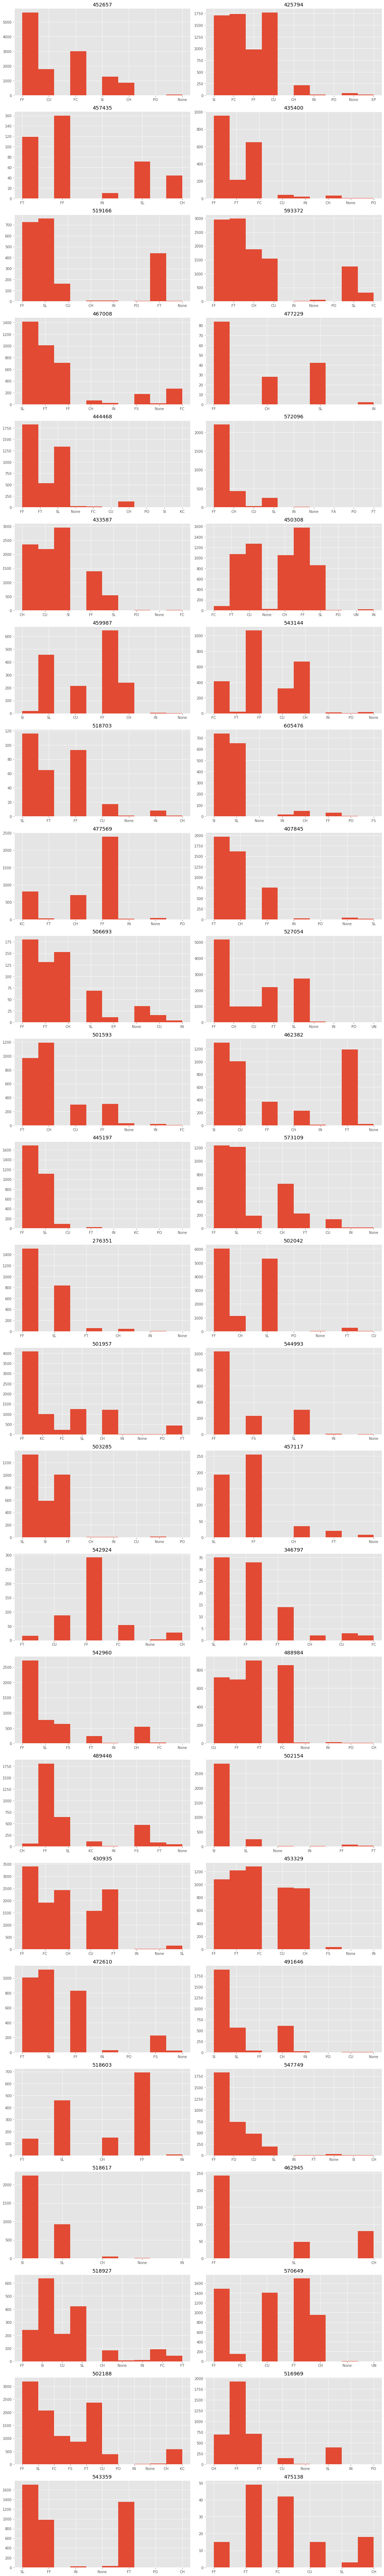

In [44]:
#looks at first 50 pitchers and observes their pitch type
fig, ax = plt.subplots(25, 2, figsize=(15, 100))
no_nan_df = game_sit.replace(np.nan, 'None')
for pitcher, ax in zip(atbats['pitcher_id'].unique()[:50], ax.flatten()):
    ax.hist(no_nan_df[no_nan_df['pitcher_id'] == pitcher]['pitch_type'])
    #ax.set_xticks()
    ax.set_title(pitcher)
    
plt.tight_layout() 